# Capstone Two - Amazon Startup Sales Analysis

This analysis will explore the sales data for a new Amazon based startup from the inception of the business in June 2018 to the present. 

The focus will be to address the disruption in sales caused by the recent Covid-19 pandemic and return business growth to pre-pandemic levels. 

The goals are:

* **Define Goal for FY2021:** Find the average growth rate prior to the onset of the pandemic.
* **Product Performance:** Focus resources towards well performing products and away from poorly performing products.
* **Marketing Strategy:** Optimize marketing according to seasonality and geographical regions.

## Initial Setup: 

### <span style="color:green">Import Libraries</span> 

**Matplotlib** - This is Python's basic plotting library.

**Datetime**

**NumPy**

**Seaborn** - This library enables you to create aesthetically pleasing plots.

**Pandas** - This library enables you to view and manipulate your data in a tabular format.

**statsmodels.api** - This library enables you to create statistical models and perform regession analysis.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as md
from matplotlib.pyplot import cm
from matplotlib.dates import DateFormatter
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

mpl.rcParams['figure.figsize'] = (20,5)

### <span style="color:green">Import Data</span> 

i. Import the sales data csv provided by Amazon into a dataframe. 

ii. Print descriptive statistics for the dataframe using **.describe()** and **.info()**

iii. Print **.head()** of dataframe for a look at the column names.

In [2]:
df_sales = pd.read_csv('C:\\Users\\Shalie\\Documents\\Springboard\\CapstoneTwo\\AmazonStartup_Transactions.csv', \
                       encoding='latin1',header=0)
df_uszips = pd.read_csv('C:\\Users\\Shalie\\Documents\\Springboard\\CapstoneTwo\\uszips.csv',header=0)

print(df_sales.info())
print(df_uszips.info())

print(df_sales.describe())

print(df_sales.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30149 entries, 0 to 30148
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date/time                 30149 non-null  object 
 1   settlement id             30149 non-null  int64  
 2   type                      29952 non-null  object 
 3   order id                  29617 non-null  object 
 4   sku                       29286 non-null  object 
 5   Department                29286 non-null  object 
 6   quantity                  29480 non-null  float64
 7   marketplace               29377 non-null  object 
 8   account type              30149 non-null  object 
 9   fulfillment               28664 non-null  object 
 10  order city                28664 non-null  object 
 11  order state               28664 non-null  object 
 12  order postal              28664 non-null  object 
 13  tax collection model      16679 non-null  object 
 14  produc

## Data Cleansing:

In [3]:
to_drop = ['settlement id', 'marketplace', 'account type', 'fulfillment', \
          'tax collection model', 'product sales tax', 'shipping credits', \
          'shipping credits tax', 'gift wrap credits', 'giftwrap credits tax', \
          'promotional rebates', 'promotional rebates tax', 'marketplace withheld tax', \
          'selling fees', 'fba fees', 'other transaction fees', 'other', 'total']

df_sales.drop(columns=to_drop, inplace=True) #drop unnecessary columns

df_sales = df_sales[df_sales['type'] == 'Order'] #remove all transactions other than Orders

# Department X was a short-lived, experimental category of products discontinued very early on.
df_sales = df_sales[df_sales['Department'] != 'X'] #remove transactions for products in Department X

df_sales['date/time'] = df_sales['date/time'].apply(lambda x: x[:-4])
df_sales['date/time'] = pd.to_datetime(df_sales['date/time'])

print(df_sales.info())

print(df_sales.describe())

print(df_sales.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27333 entries, 2 to 30148
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date/time      27333 non-null  datetime64[ns]
 1   type           27333 non-null  object        
 2   order id       27333 non-null  object        
 3   sku            27333 non-null  object        
 4   Department     27333 non-null  object        
 5   quantity       27333 non-null  float64       
 6   order city     27333 non-null  object        
 7   order state    27333 non-null  object        
 8   order postal   27333 non-null  object        
 9   product sales  27333 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 1.6+ MB
None
           quantity  product sales
count  27333.000000   27333.000000
mean       1.114953      26.828133
std        0.445592      17.538571
min        1.000000       0.000000
25%        1.000000      11.

In [4]:
df_sales.reset_index(level=0, inplace=True)
df_sales.drop(columns=['index'], inplace=True)

# Normalize all zipcodes in df_uszips to 5-digit format and save to new column 'zip_5'
df_uszips['zip'] = df_uszips['zip'].apply(str)
df_uszips['zip_5'] = df_uszips['zip'].apply(lambda x: x[:5])
df_uszips['zip_5'] = df_uszips['zip_5'].apply(int)
df_uszips.set_index('zip_5', inplace=True)

# Normalize all zipcodes in df_sales to 5-digit format and save to new column 'zip_5'
df_sales['order postal'] = df_sales['order postal'].apply(str)
df_sales['zip_5'] = df_sales['order postal'].apply(lambda x: x[:5])
df_sales['zip_5'] = df_sales['zip_5'].apply(int)

# Look up order zipcode in uszips and assign correct state id
states = []

for i in range(27333) :
    if df_sales.iloc[i]['zip_5'] in df_uszips.index :
        x = df_uszips.loc[df_sales.iloc[i]['zip_5']]['state_id']
    else : x = 'NaN'
    states.append(x)

# Save list of state ids to df_sales
df_states = pd.DataFrame(states)
df_sales['state_id'] = df_states

print(df_sales.head())

            date/time   type             order id          sku Department  \
0 2018-06-24 21:07:49  Order  112-9360695-9606611  Product AG1          A   
1 2018-06-24 21:38:06  Order  114-4232049-1758605  Product AG1          A   
2 2018-06-24 22:44:32  Order  113-4119975-6952235  Product AG1          A   
3 2018-06-25 10:45:48  Order  111-8432552-1184205  Product AG1          A   
4 2018-06-25 19:31:33  Order  112-6350587-7686619  Product AG1          A   

   quantity   order city order state order postal  product sales  zip_5  \
0       1.0   Fort Worth       Texas        76126          19.99  76126   
1       1.0  BELLA VISTA          AR   72714-3708          19.99  72714   
2       1.0   FORT WORTH          TX   76126-6047          19.99  76126   
3       1.0    PENSACOLA          FL   32508-5245          19.99  32508   
4       1.0       MERKEL          TX   79536-6008          19.99  79536   

  state_id  
0       TX  
1       AR  
2       TX  
3       FL  
4       TX  


## Define Goal for FY2021:

i. Compare YoY growth for total gross revenue to ascertain sales growth target for FY2021.

ii. Repeat analysis grouping by department.

### <span style="color:green">Step One: Total Gross Revenue</span> 

In [5]:
# Create new column of months to group by
df_sales['Year_Month'] = df_sales['date/time'].apply(lambda x: x.strftime('%Y-%m'))
df_sales['Year_Month'] = pd.to_datetime(df_sales['Year_Month'])

# Add gross revenue per month
Total_Rev_Monthly = df_sales.groupby('Year_Month').sum()

# Group into series by year
total_sales_yearly = pd.pivot_table(Total_Rev_Monthly, index=Total_Rev_Monthly.index.month, columns=Total_Rev_Monthly.index.year,
                    values='product sales', aggfunc='sum')
print(total_sales_yearly.sum())

Year_Month
2018     42077.58
2019    355077.35
2020    336138.43
dtype: float64


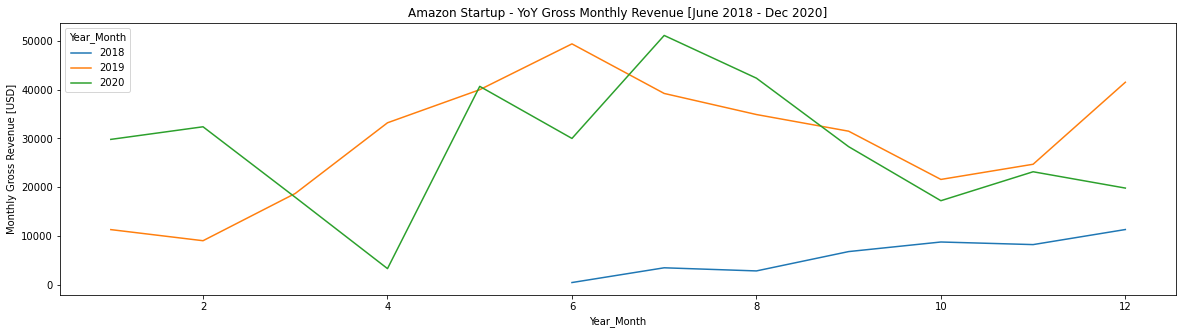

In [6]:
# Plot Year over Year, Monthly Gross Revenue
_ = total_sales_yearly.plot()

_ = plt.ylabel('Monthly Gross Revenue [USD]')
_ = plt.title('Amazon Startup - YoY Gross Monthly Revenue [June 2018 - Dec 2020]')

            product sales  Last_Year    Growth
Year_Month                                    
2019-06-01       49366.21     486.83  48879.38
2019-07-01       39212.41    3506.97  35705.44
2019-08-01       34895.15    2866.20  32028.95
2019-09-01       31481.46    6827.73  24653.73
2019-10-01       21604.38    8789.27  12815.11


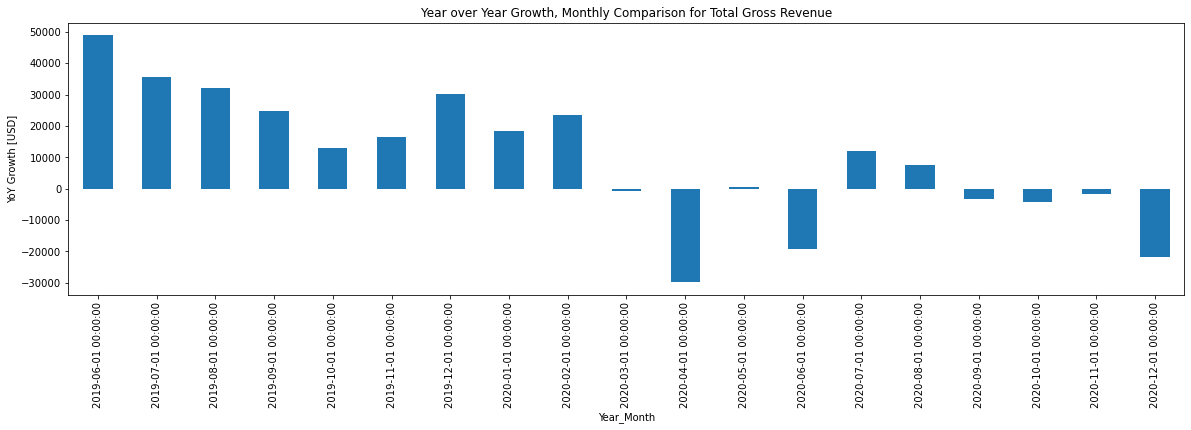

In [7]:
# Determine Year over Year Growth in USD for each month following the first year of operations

# Aggregate revenue grouping by months
YoY_Data = pd.DataFrame(df_sales.groupby('Year_Month').sum()['product sales'])
# Create a new column called Last Year to use in calculating YoY growth
YoY_Data['Last_Year'] = np.roll(YoY_Data['product sales'],12)
YoY_Data = YoY_Data.drop(YoY_Data.index[0:12]) #drop first 12 months which contain unusable data
YoY_Data['Growth'] = YoY_Data['product sales'] - YoY_Data['Last_Year'] #calculate YoY growth

print(YoY_Data.head())

_ = YoY_Data['Growth'].plot(kind='bar')
#_ = plt.ylim(top=40000)
#_ = plt.ylim(bottom=-40000)
_ = plt.title('Year over Year Growth, Monthly Comparison for Total Gross Revenue')
_ = plt.ylabel('YoY Growth [USD]')

plt.show()

In [8]:
# From this intial analysis, it would appear the company had leveled out to a fairly even growth rate
# from Sept 2019 to Feb 2020.
# Starting March 2020, sales were drastically affected by the pandemic.

Goal = YoY_Data['2019-09':'2020-02'].mean()
Current_Growth = YoY_Data['2020-03':].mean()

print('Average YoY sales growth 09-19 to 02-20:\n')
print(round(Goal['Growth'],2), ' USD YoY growth')
print('\n')
print('Average YoY pandemic sales growth 03-20 to Present:\n')
print(round(Current_Growth['Growth'],2), ' USD YoY growth')

Average YoY sales growth 09-19 to 02-20:

20983.4  USD YoY growth


Average YoY pandemic sales growth 03-20 to Present:

-6075.02  USD YoY growth


### <span style="color:green">Step Two: Total Gross Revenue by Department</span> 

In [9]:
# Separate sales by Department
df_sales_A = df_sales[df_sales['Department'] == 'A']
df_sales_B = df_sales[df_sales['Department'] == 'B']

# Aggregate sales for both departments by week
Rev_Weekly_A = df_sales_A.groupby(pd.Grouper(key='date/time', freq='W-MON')).sum()
Rev_Weekly_B = df_sales_B.groupby(pd.Grouper(key='date/time', freq='W-MON')).sum()

# Combine both departments sales columns side by side in new dataframe
Dept_Rev_Weekly = pd.DataFrame(data=Rev_Weekly_A['product sales'], \
                                index=Rev_Weekly_A.index)
Dept_Rev_Weekly.columns = ['product sales - Dept A']
Dept_Rev_Weekly['product sales - Dept B'] = Rev_Weekly_B['product sales']

# Create rolling average of total gross revenue using a four-week window
Total_Rev_Weekly = df_sales.groupby(pd.Grouper(key='date/time', freq='W-MON')).sum()
Total_Rev_Weekly_Rolling = Total_Rev_Weekly['product sales'].rolling(4).mean()
Total_Rev_Weekly_Rolling.columns = ['Total Rev - Rolling Mean']

print('Total Revenue in 2019: \n')
print(Dept_Rev_Weekly['2019'].sum())

print('\n')

print('Total Revenue in 2020: \n')
print(Dept_Rev_Weekly['2020'].sum())

Total Revenue in 2019: 

product sales - Dept A    200336.57
product sales - Dept B    154394.99
dtype: float64


Total Revenue in 2020: 

product sales - Dept A    158837.45
product sales - Dept B    177646.77
dtype: float64


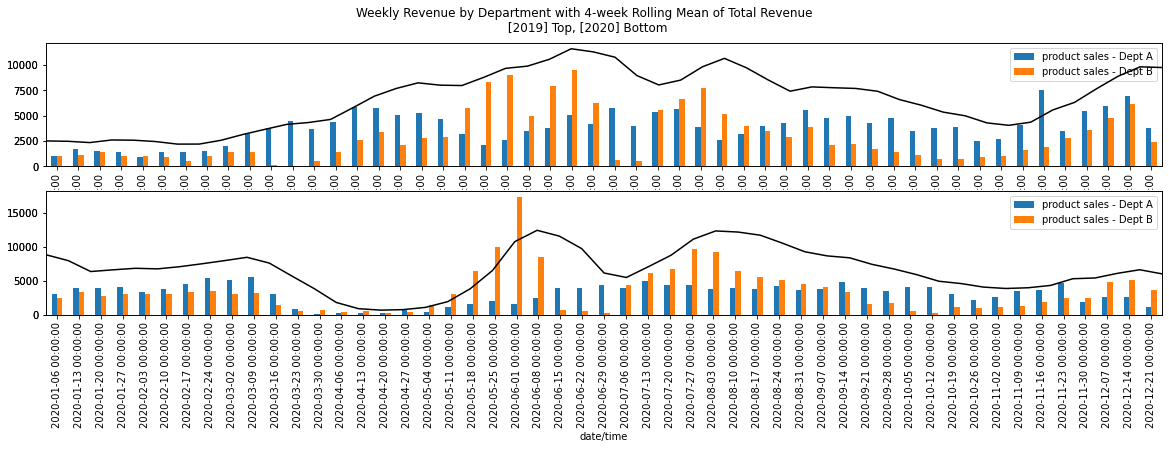

In [10]:
# Set up Subplots, one per year (2019 and 2020) and plot dept totals and rolling mean in both
fig, (ax, ax2) = plt.subplots(2)
fig.suptitle('Weekly Revenue by Department with 4-week Rolling Mean of Total Revenue \n [2019] Top, [2020] Bottom')

#First Subplot for 2019
ax3 = ax.twiny()

Dept_Rev_Weekly['2019'].plot(kind='bar', ax=ax)

Total_Rev_Weekly_Rolling['2019'].plot(kind='line', ax=ax3, color='black')

ax3.get_xaxis().set_visible(False) # Hide upper x axis

# Second Subplot for 2020
ax4 = ax2.twiny()

Dept_Rev_Weekly['2020'].plot(kind='bar', ax=ax2)

Total_Rev_Weekly_Rolling['2020'].plot(kind='line', ax=ax4, color='black')

ax4.get_xaxis().set_visible(False) # Hide upper x axis

plt.show()

                       product sales  Last_Year    Growth
Year_Month Department                                    
2019-08-01 A                15589.72    2506.28  13083.44
2019-09-01 A                20619.76    6106.90  14512.86
2019-10-01 A                17155.42    7821.49   9333.93
2019-11-01 A                17858.51    5934.15  11924.36
2019-12-01 A                23590.67    4679.52  18911.15


                       product sales  Last_Year    Growth
Year_Month Department                                    
2019-08-01 B                19305.43     359.92  18945.51
2019-09-01 B                10861.70     720.83  10140.87
2019-10-01 B                 4448.96     967.78   3481.18
2019-11-01 B                 6854.31    2323.46   4530.85
2019-12-01 B                17917.42    6663.45  11253.97


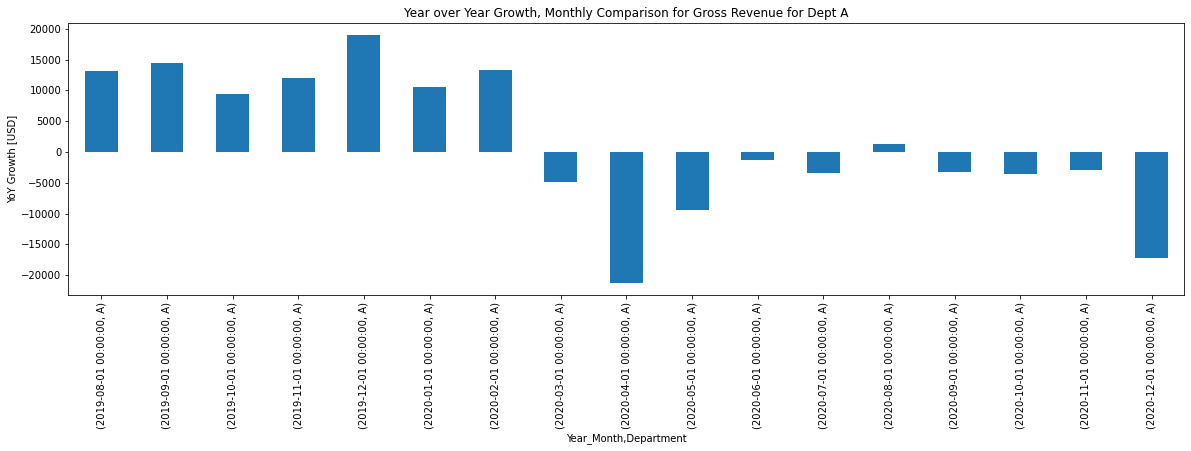

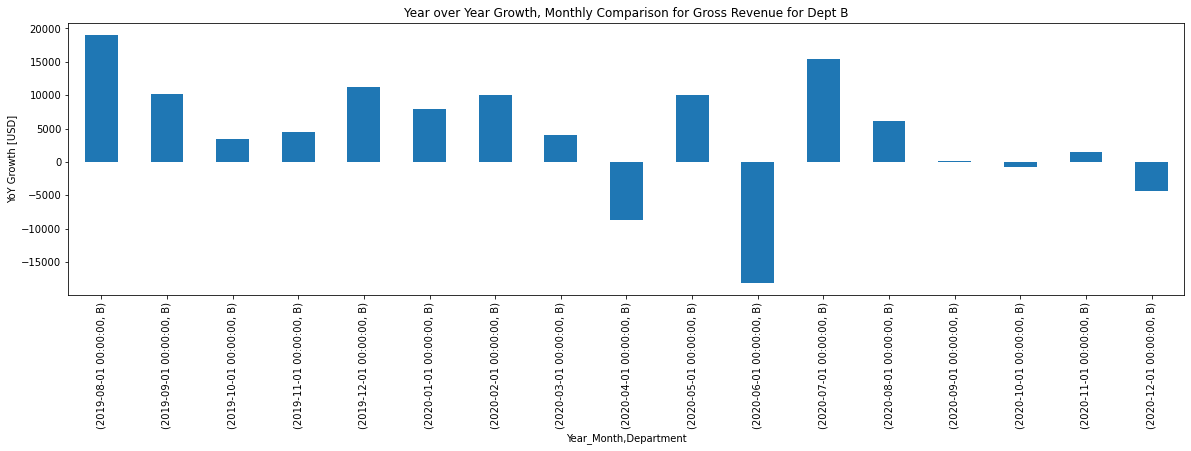

In [11]:
# Summing sales by Department and Year_Month
YoY_Data_Dept = pd.DataFrame(df_sales.groupby(['Year_Month', 'Department']).sum()['product sales'])
# Dropping months before Dept B started
YoY_Data_Dept = YoY_Data_Dept.drop(YoY_Data_Dept.index[0:2])
# Create column with Last Year's month's numbers for comparison
YoY_Data_Dept['Last_Year'] = np.roll(YoY_Data_Dept['product sales'],24)
YoY_Data_Dept = YoY_Data_Dept.drop(YoY_Data_Dept.index[0:24])
# Calculate Growth Rate
YoY_Data_Dept['Growth'] = YoY_Data_Dept['product sales'] - YoY_Data_Dept['Last_Year']

YoY_Data_Dept_A = YoY_Data_Dept.loc[(slice(None), "A"), :]
YoY_Data_Dept_B = YoY_Data_Dept.loc[(slice(None), "B"), :]

print(YoY_Data_Dept_A.head())
print('\n')
print(YoY_Data_Dept_B.head())

# Plot YoY growth for each department
for x in ['A', 'B'] :
    YoY_Data_Dept_x = YoY_Data_Dept.loc[(slice(None), x), :]
    _ = YoY_Data_Dept_x['Growth'].plot(kind='bar')
    #_ = plt.ylim(top=8)
    #_ = plt.ylim(bottom=-2)
    _ = plt.title('Year over Year Growth, Monthly Comparison for Gross Revenue for Dept ' + x)
    _ = plt.ylabel('YoY Growth [USD]')
    plt.show()

In [12]:
# It appears that both departments' sales were noticeably affected by the pandemic.
# Neither stands out as significantly worse affected than the other.
# Here, I'll calculate the respective goals for next year.

Goal_A = YoY_Data_Dept_A['2019-10-01':'2020-02-01']['Growth'].mean()
Goal_B = YoY_Data_Dept_B['2019-10-01':'2020-02-01']['Growth'].mean()

Current_Growth_A = YoY_Data_Dept_A['2020-03-01':]['Growth'].mean()
Current_Growth_B = YoY_Data_Dept_B['2020-03-01':]['Growth'].mean()

print('Average monthly YoY sales growth 10-19 to 02-20:\n')
print('Dept A: ',round(Goal_A,2),'USD YoY, Dept B: ', round(Goal_B,2),'USD YoY')
print('\n')
print('Average monthly YoY pandemic sales growth 03-20 to Present:\n')
print('Dept A: ', round(Current_Growth_A,2), 'USD YoY, Dept B: ', round(Current_Growth_B,2), 'USD YoY')

print('\n The goal for FY2021 is to return to an average monthly YoY growth matching that of pre-pandemic YoY growth')

Average monthly YoY sales growth 10-19 to 02-20:

Dept A:  12820.63 USD YoY, Dept B:  7428.7 USD YoY


Average monthly YoY pandemic sales growth 03-20 to Present:

Dept A:  -6603.44 USD YoY, Dept B:  528.43 USD YoY

 The goal for FY2021 is to return to an average monthly YoY growth matching that of pre-pandemic YoY growth


## Product Performance:

i. Determine which products sell the most by quantity.

ii. Determine which products bring in the greatest total revenue.

### <span style="color:green">Step One: Products by Popularity</span> 

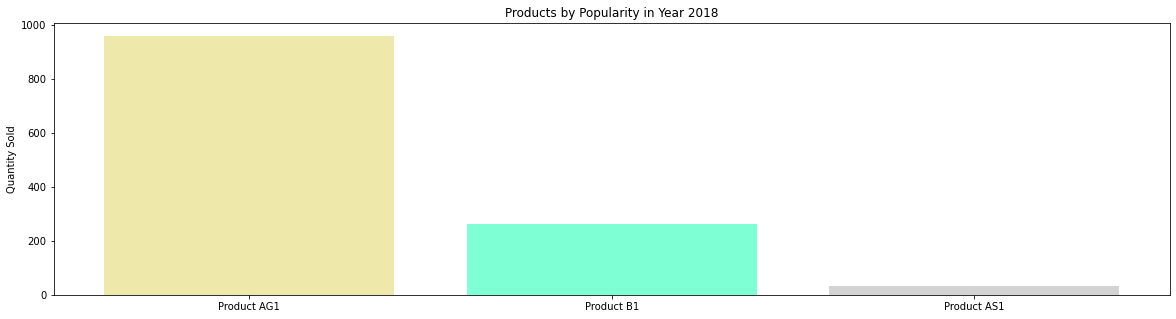

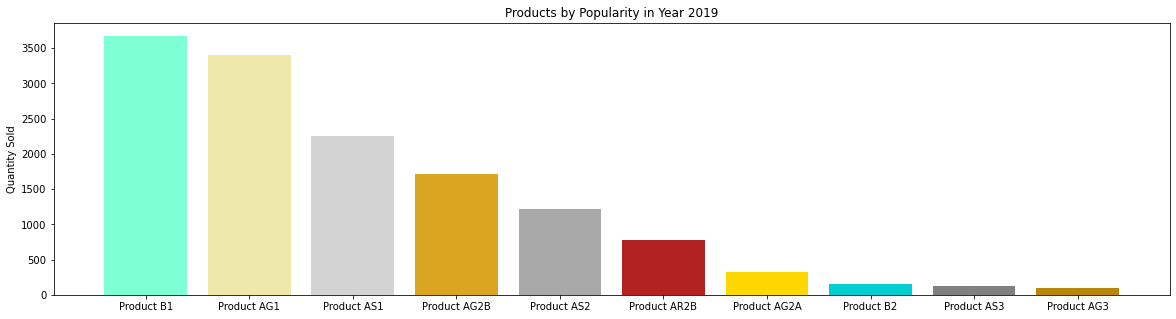

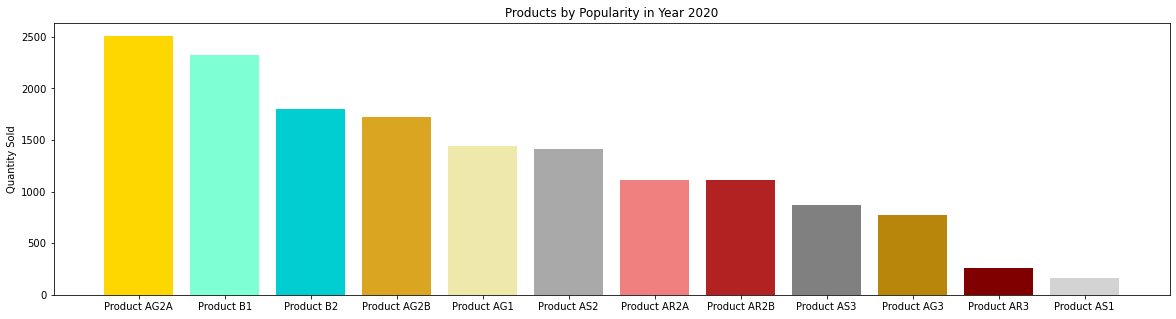

In [13]:
# Top Selling Products by Year
df_sales.set_index('date/time', inplace=True)

prod_colors = {'Product AS1':'lightgray', 'Product AS2':'darkgray', 'Product AS3':'gray', \
               'Product AG1':'palegoldenrod', 'Product AG2A':'gold', 'Product AG2B':'goldenrod', 'Product AG3':'darkgoldenrod', \
               'Product AR2A':'lightcoral', 'Product AR2B':'firebrick', 'Product AR3':'maroon', \
               'Product B1':'aquamarine', 'Product B2':'darkturquoise'}

for x in [2018, 2019, 2020] :
    #For each year, sum quantity sold for each different product
    Product_Pop_x = pd.DataFrame(df_sales[df_sales.index.year == x].groupby('sku').sum()['quantity'])
    #Sort by popularity
    Product_Pop_x.sort_values(by=['quantity'], inplace=True, ascending=False)
    #Reset sku to typical column for ease of plotting
    Product_Pop_x.reset_index(level=0, inplace=True)
    #Plot ranking of products for each year
    fig, ax = plt.subplots()
    _ = ax.bar(Product_Pop_x['sku'], Product_Pop_x['quantity'], \
               color=Product_Pop_x['sku'].apply(lambda c: prod_colors[c]))
    plt.title('Products by Popularity in Year ' + str(x))
    plt.ylabel('Quantity Sold')

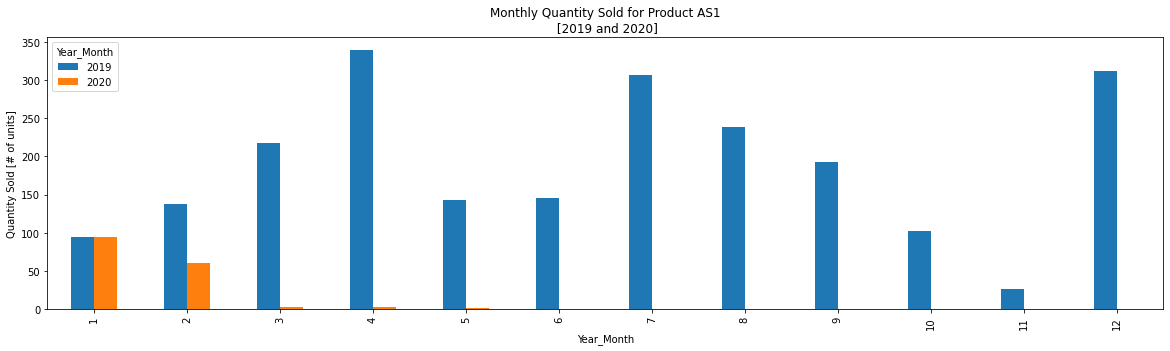

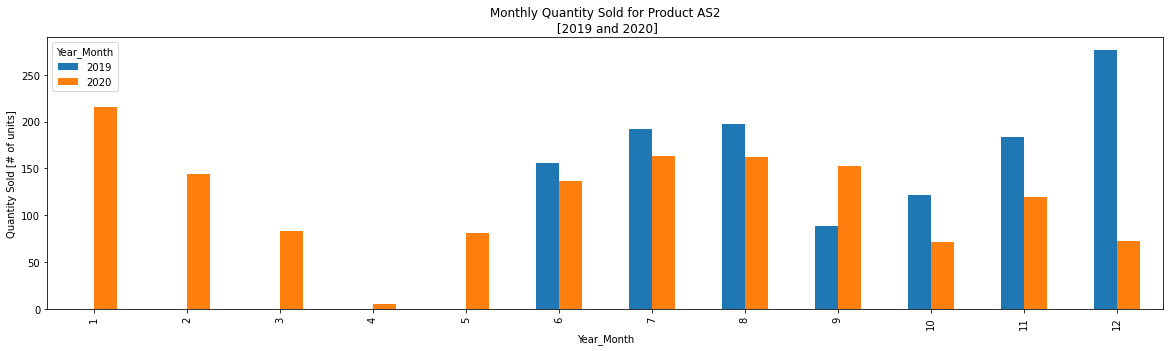

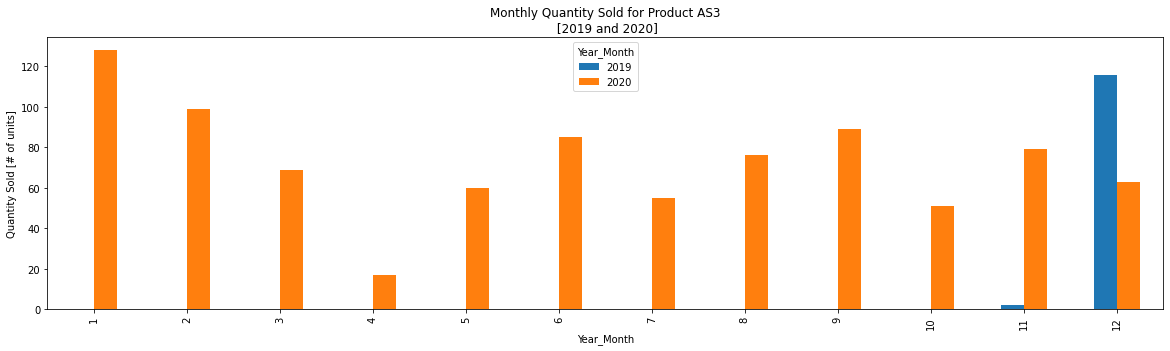

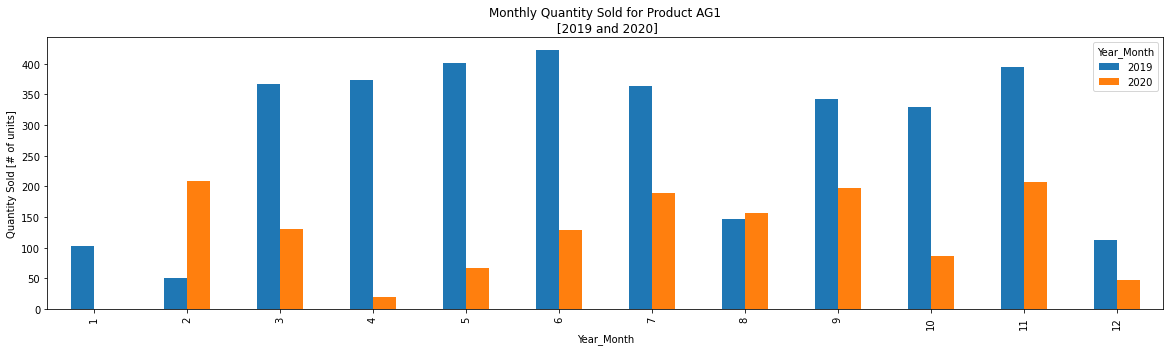

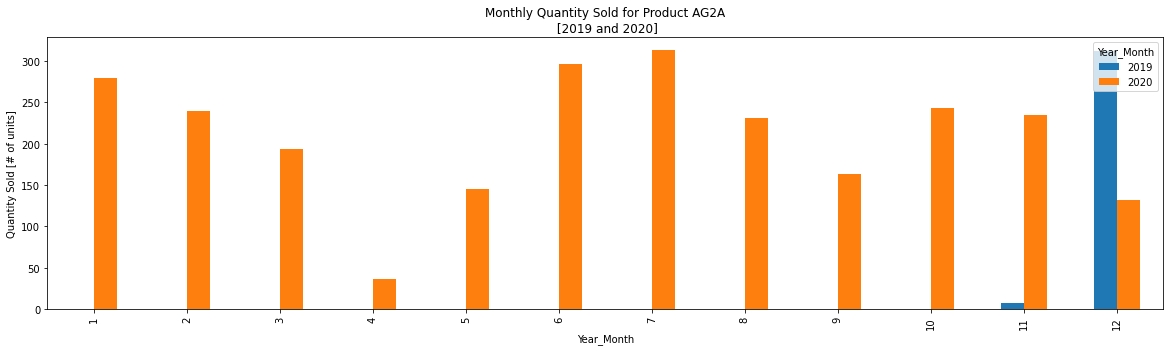

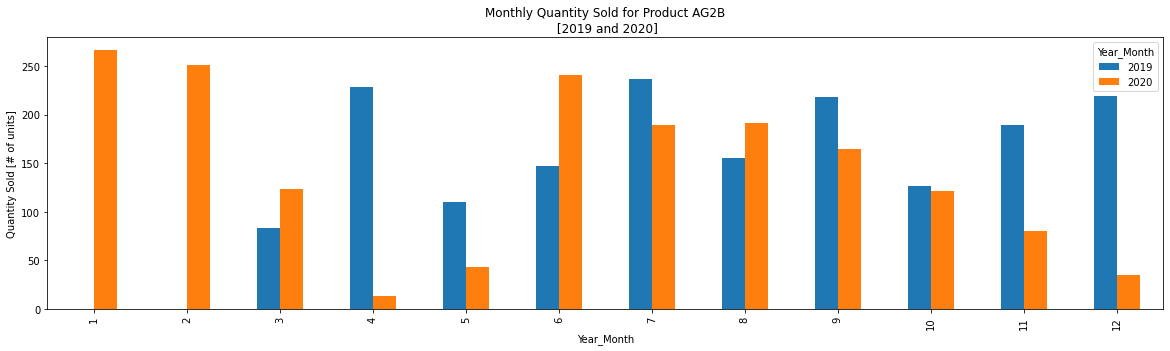

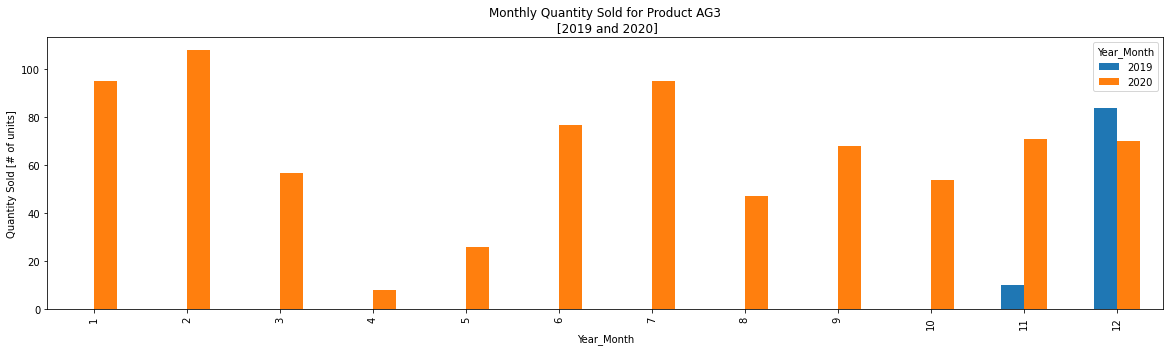

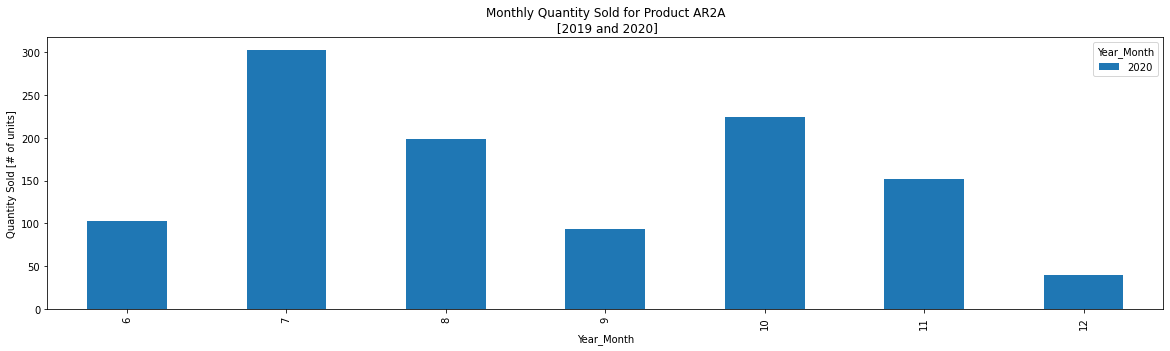

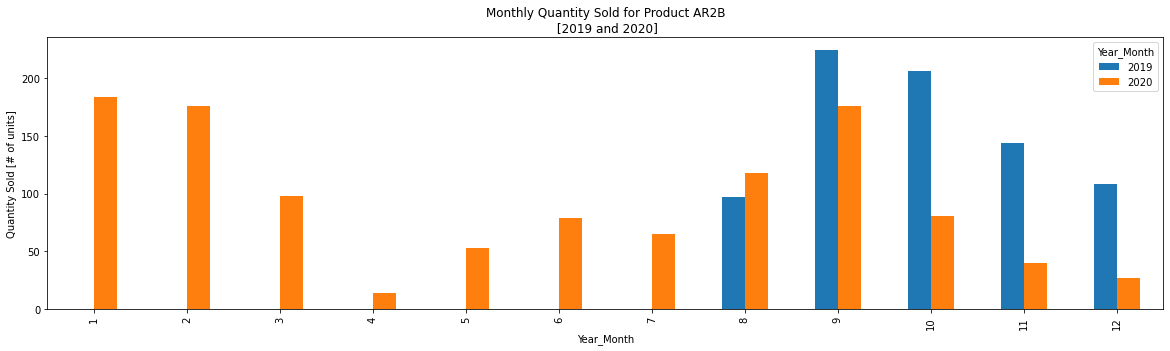

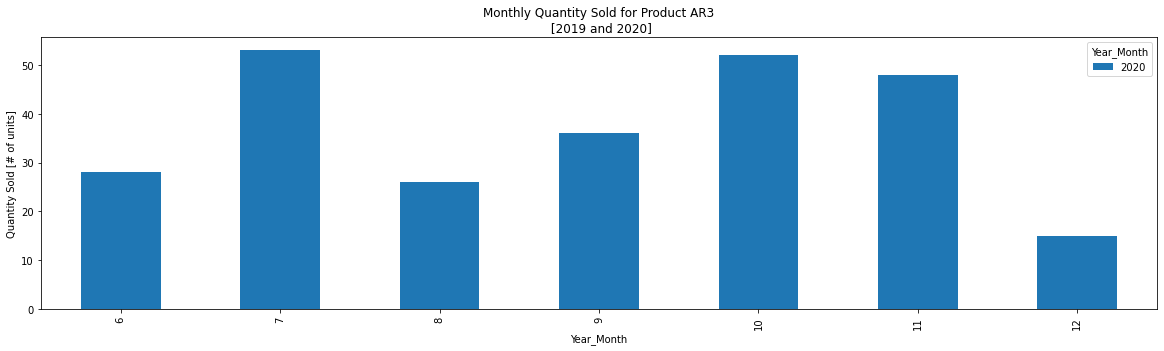

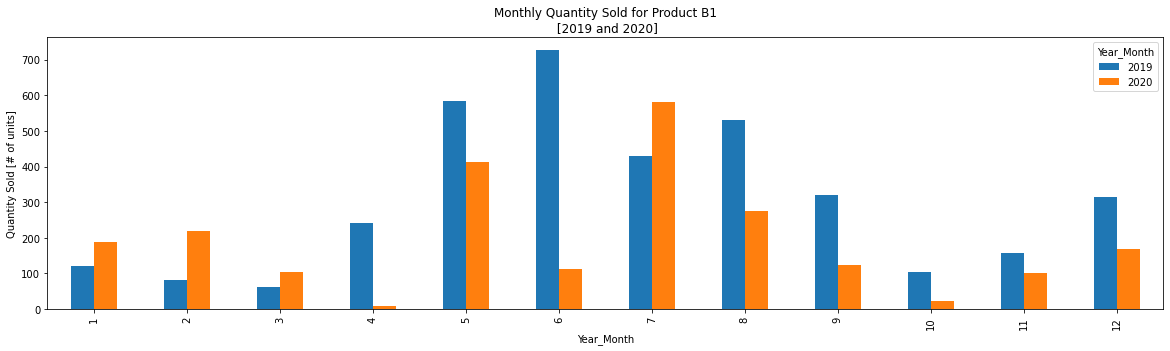

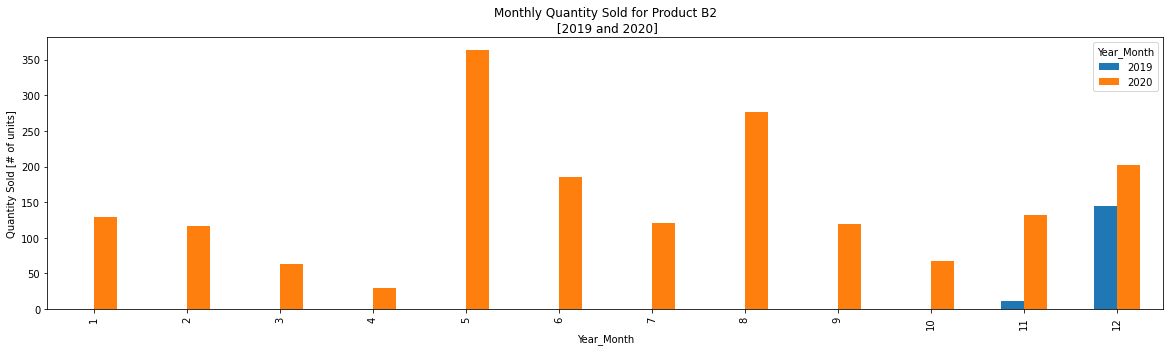

In [14]:
# Series of Bar Chart plots for each product with monthly quantity, grouped by year

SKUs = ['Product AS1', 'Product AS2', 'Product AS3', \
        'Product AG1', 'Product AG2A', 'Product AG2B', 'Product AG3', \
        'Product AR2A', 'Product AR2B', 'Product AR3', \
        'Product B1', 'Product B2']

Product_Pop_Monthly = pd.DataFrame(df_sales.groupby(['Year_Month', 'sku']).sum()['quantity'])
Product_Pop_Monthly.reset_index(level=1, inplace=True)
Product_Pop_Monthly_19_20 = Product_Pop_Monthly['2019'].append(Product_Pop_Monthly['2020'])
#print(Product_Pop_Monthly_19_20.head())

for x in SKUs :
    Product_Pop_Monthly_x = Product_Pop_Monthly_19_20[Product_Pop_Monthly_19_20['sku'] == x]
    Product_Pop_Monthly_x_yearly = pd.pivot_table(Product_Pop_Monthly_x, index=Product_Pop_Monthly_x.index.month, \
                                                  columns=Product_Pop_Monthly_x.index.year, values='quantity', aggfunc='sum')
    _=Product_Pop_Monthly_x_yearly.plot(kind='bar')
    _=plt.title('Monthly Quantity Sold for ' + x + '\n [2019 and 2020]')
    _=plt.ylabel('Quantity Sold [# of units]')
    plt.show()

### <span style="color:green">Step Two: Highest Earning Products Overall</span> 

             sku  mean quantity  mean price  mean revenue
0    Product AG1     119.833333   24.553571   2897.220000
1   Product AG2A     209.000000   11.373321   2374.328333
2   Product AG2B     143.166667   16.736809   2418.081667
3    Product AG3      64.666667   10.915708    704.353333
4   Product AR2A     159.142857   11.566836   1829.268571
5   Product AR2B      92.583333   16.930619   1580.322500
6    Product AR3      36.857143   11.030140    410.345714
7    Product AS1      32.400000   22.868460    738.694000
8    Product AS2     117.333333    8.848635   1026.076667
9    Product AS3      72.583333    8.268397    596.774167
10    Product B1     193.583333   37.640434   7658.400833
11    Product B2     150.416667   46.850002   7141.747500


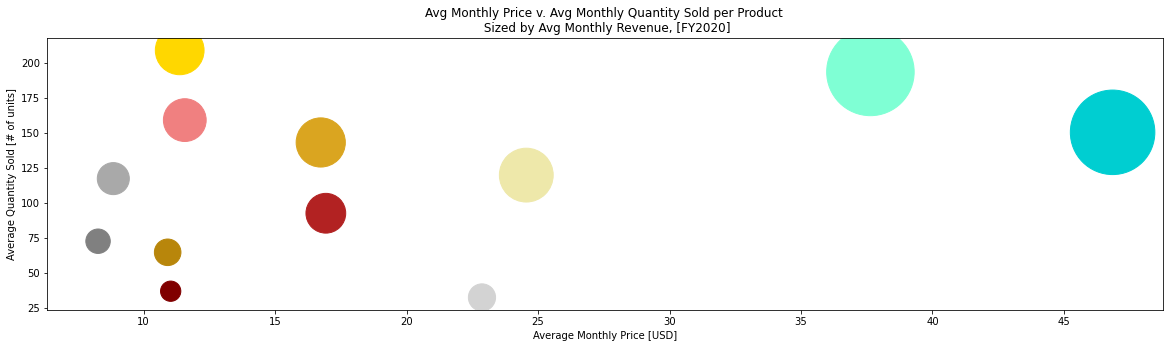

In [15]:
# Now that we know which products are sold the most by quantity,
# let's analyse whether this is associated with the products which generate the most revenue.

# Aggregate transactions grouping by month and product sku
Sales_Monthly = pd.DataFrame(df_sales.groupby(['Year_Month', 'sku']).sum())
# Calculate new column for price
Sales_Monthly['price'] = Sales_Monthly['product sales']/Sales_Monthly['quantity']
Sales_Monthly.reset_index(level=1, inplace=True)
# perform this association analysis only for FY2020 because there were new products introduced in FY2019
Sales_Monthly_20 = Sales_Monthly['2020']
#print(Sales_Monthly_20)

# Quantity: Calculate average monthly quantity sold for each product
Quantity_Monthly_20_pv = pd.pivot_table(Sales_Monthly_20, index=Sales_Monthly_20.index, \
                                                  columns=Sales_Monthly_20['sku'], values='quantity', aggfunc='sum')
Avg_Quantity_20 = pd.DataFrame(Quantity_Monthly_20_pv.mean())
Avg_Quantity_20.columns = ['mean quantity']
#print(Avg_Quantity_20)

# Price: Calculate average monthly price for each product
Prices_Monthly_20_pv = pd.pivot_table(Sales_Monthly_20, index=Sales_Monthly_20.index, \
                                                  columns=Sales_Monthly_20['sku'], values='price', aggfunc='sum')
Avg_Prices_20 = pd.DataFrame(Prices_Monthly_20_pv.mean())
Avg_Prices_20.columns = ['mean price']
#print(Avg_Prices_20)

# Revenue: Calculate average monthly gross revenue for each product
Revenue_Monthly_20_pv = pd.pivot_table(Sales_Monthly_20, index=Sales_Monthly_20.index, \
                                                  columns=Sales_Monthly_20['sku'], values='product sales', aggfunc='sum')
Avg_Revenue_20 = pd.DataFrame(Revenue_Monthly_20_pv.mean())
Avg_Revenue_20.columns = ['mean revenue']
#print(Avg_Revenue_20)

# And all together now...
Product_Avgs_20 = Avg_Quantity_20
Product_Avgs_20['mean price'] = Avg_Prices_20['mean price']
Product_Avgs_20['mean revenue'] = Avg_Revenue_20['mean revenue']
Product_Avgs_20.reset_index(level=0, inplace=True)
print(Product_Avgs_20)

# Create scatter plot to visualize association pattern
fig, ax = plt.subplots()
_=ax.scatter(Product_Avgs_20['mean price'], Product_Avgs_20['mean quantity'], \
           s=Product_Avgs_20['mean revenue'], c=Product_Avgs_20['sku'].apply(lambda c: prod_colors[c]), alpha=1)

_=plt.title('Avg Monthly Price v. Avg Monthly Quantity Sold per Product \n Sized by Avg Monthly Revenue, [FY2020]')
_=plt.xlabel('Average Monthly Price [USD]')
_=plt.ylabel('Average Quantity Sold [# of units]')

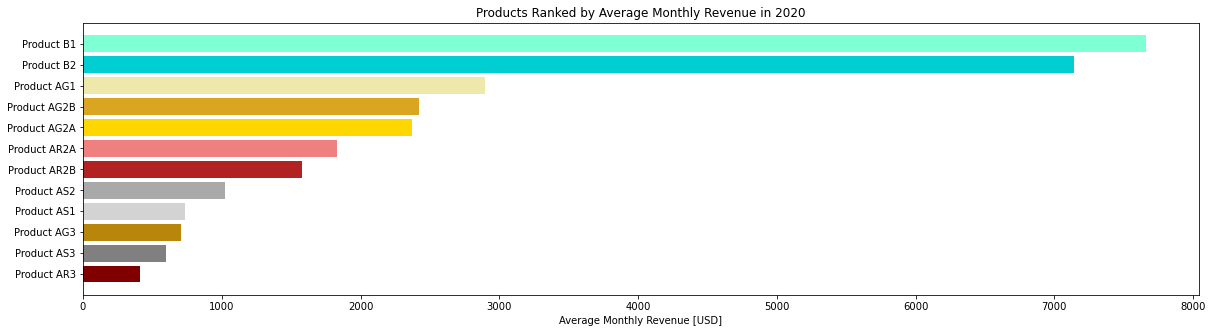

In [16]:
# Rank products by average monthly gross revenue
Avg_Revenue_20.sort_values(by=['mean revenue'], inplace=True, ascending=True)
Avg_Revenue_20.reset_index(level=0, inplace=True)
_=plt.barh(Avg_Revenue_20['sku'], Avg_Revenue_20['mean revenue'], color=Avg_Revenue_20['sku'].apply(lambda c: prod_colors[c]))
_=plt.title('Products Ranked by Average Monthly Revenue in 2020')
_=plt.xlabel('Average Monthly Revenue [USD]')

## Marketing Strategy:

### <span style="color:green">Step One: Seasonality</span> 

In [17]:
# Plot year over year for 2019 and 2020 to identify seasonality for each department

# Reference separate sales by Department from earlier kernel
    # df_sales_A contains all sales transactions for Dept A
    # df_sales_B contains all sales transactions for Dept B

# Aggregate sales for both departments by week
WeeklyQuantity_A = pd.DataFrame(Rev_Weekly_A['quantity']) # = df_sales_A.groupby(pd.Grouper(key='date/time', freq='W-MON')).sum()
WeeklyQuantity_B = pd.DataFrame(Rev_Weekly_B['quantity']) # = df_sales_B.groupby(pd.Grouper(key='date/time', freq='W-MON')).sum()

# Remove FY2018 because they business was just getting started
WeeklyQuantity_A_19_20 = WeeklyQuantity_A['2019'].append(WeeklyQuantity_A['2020'])
WeeklyQuantity_B_19_20 = WeeklyQuantity_B['2019'].append(WeeklyQuantity_B['2020'])

# Create rolling average of quantity sold using a four-week window for each department
WeeklyQuantity_A_19_20['Quantity Rolling Avg'] = WeeklyQuantity_A_19_20['quantity'].rolling(4).mean()
WeeklyQuantity_B_19_20['Quantity Rolling Avg'] = WeeklyQuantity_B_19_20['quantity'].rolling(4).mean()

# Pivot to create columns for separate years, pivot won't cooperate with week attribute
# First, Dept A:
WeeklyQuantity_A_Yr = pd.DataFrame(WeeklyQuantity_A_19_20['2019']['Quantity Rolling Avg'])
WeeklyQuantity_A_Yr.reset_index(level=0, inplace=True)
WeeklyQuantity_A_Yr.columns = ['2019 Dates','2019']

WeeklyQuantity_A_Yr_20 = pd.DataFrame(WeeklyQuantity_A_19_20['2020']['Quantity Rolling Avg'])
WeeklyQuantity_A_Yr_20.reset_index(level=0, inplace=True)
WeeklyQuantity_A_Yr_20.columns = ['2020 Dates','2020']

WeeklyQuantity_A_Yr['2020'] = WeeklyQuantity_A_Yr_20['2020']
WeeklyQuantity_A_Yr.drop(columns=['2019 Dates'], inplace=True)

# Then, Dept B:
WeeklyQuantity_B_Yr = pd.DataFrame(WeeklyQuantity_B_19_20['2019']['Quantity Rolling Avg'])
WeeklyQuantity_B_Yr.reset_index(level=0, inplace=True)
WeeklyQuantity_B_Yr.columns = ['2019 Dates','2019']

WeeklyQuantity_B_Yr_20 = pd.DataFrame(WeeklyQuantity_B_19_20['2020']['Quantity Rolling Avg'])
WeeklyQuantity_B_Yr_20.reset_index(level=0, inplace=True)
WeeklyQuantity_B_Yr_20.columns = ['2020 Dates','2020']

WeeklyQuantity_B_Yr['2020'] = WeeklyQuantity_B_Yr_20['2020']
WeeklyQuantity_B_Yr.drop(columns=['2019 Dates'], inplace=True)

#WeeklyQuantity_A_Yr = pd.pivot_table(WeeklyQuantity_A_19_20, index=WeeklyQuantity_A_19_20.index.week, \
#                                     columns=WeeklyQuantity_A_19_20.index.year, values='Quantity Rolling Avg', aggfunc='sum')
#WeeklyQuantity_B_Yr = pd.pivot_table(WeeklyQuantity_B_19_20, index=WeeklyQuantity_B_19_20.index.week, \
#                                     columns=WeeklyQuantity_B_19_20.index.year, values='Quantity Rolling Avg', aggfunc='sum')

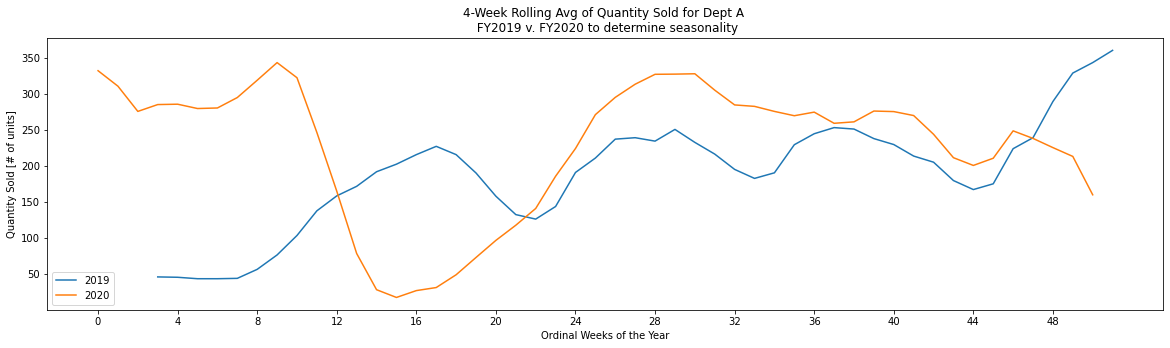

In [18]:
# Plot Weekly Rolling Avg of Quantity Sold for Dept A, both FY2019 and FY2020 to visualize YoY seasonality
WeeklyQuantity_A_Yr.plot(kind='line')

_=plt.title('4-Week Rolling Avg of Quantity Sold for Dept A \n FY2019 v. FY2020 to determine seasonality')
_=plt.ylabel('Quantity Sold [# of units]')
_=plt.xlabel('Ordinal Weeks of the Year')
_=plt.xticks(np.arange(min(WeeklyQuantity_A_Yr.index), max(WeeklyQuantity_A_Yr.index)+1, 4.0))
plt.show()

In [18]:
# From this plot, I would say that Dept A does not appear to have overly significant seasonality.
# Taking into consideration outside factors, such as inconsistency stocking products, sales seem to be pretty level,
# and possibly growing at a steady rate before the pandemic so heavily affected product availability around Apr-2020.

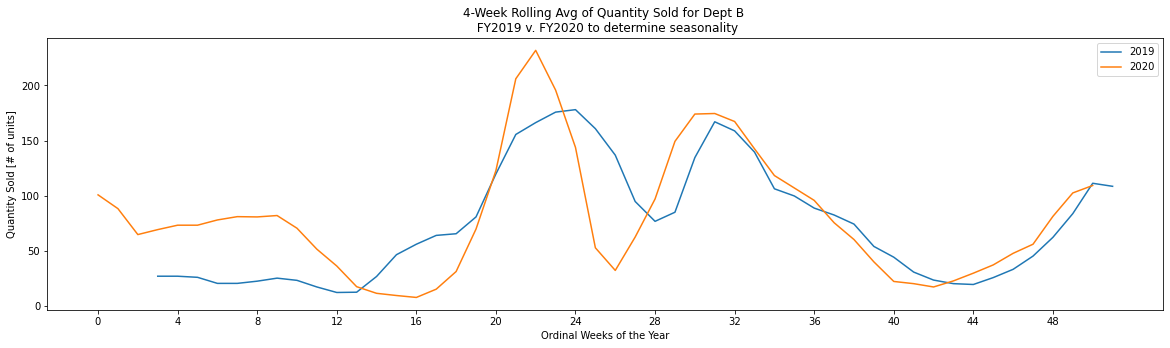

In [19]:
# Plot Weekly Rolling Avg of Quantity Sold for Dept B, both FY2019 and FY2020 to visualize YoY seasonality
WeeklyQuantity_B_Yr.plot(kind='line')

_=plt.title('4-Week Rolling Avg of Quantity Sold for Dept B \n FY2019 v. FY2020 to determine seasonality')
_=plt.ylabel('Quantity Sold [# of units]')
_=plt.xlabel('Ordinal Weeks of the Year')
_=plt.xticks(np.arange(min(WeeklyQuantity_B_Yr.index), max(WeeklyQuantity_B_Yr.index)+1, 4.0))
plt.show()

In [20]:
# Unlike Dept A, Dept B has very obvious summer seasonality spanning approximately May to September.
# The midsummer dip during both years are unrelated to seasonality even though there is a deceptive pattern there.

# In 2019, the Inventory Manager underestimated market demand and under-stocked the product.

# In 2020, Amazon received the summer shipment, but then did not check it in to the system for 3 or 4 weeks.
# This significantly affected sales.

### <span style="color:green">Step Two: Regionality</span> 

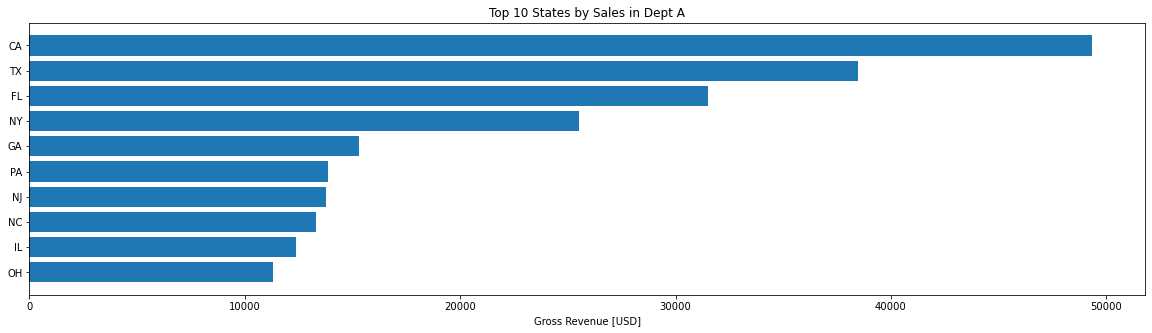

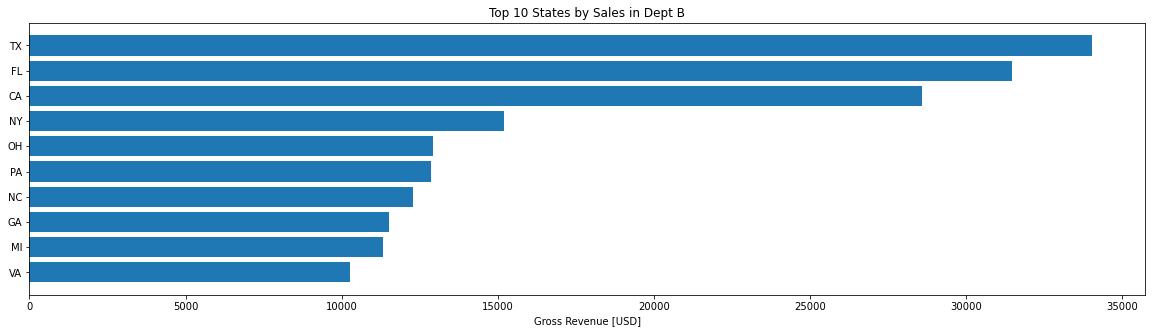

In [20]:
# Find top ten states by revenue for each department

for x in ['A', 'B'] :
    #For department, sum revenue for each state
    State_Sales_x = pd.DataFrame(df_sales[df_sales['Department'] == x].groupby('state_id').sum()['product sales'])
    #Sort by revenue
    State_Sales_x.sort_values(by=['product sales'], inplace=True, ascending=False)
    #Reset state_id to typical column for ease of plotting
    State_Sales_x.reset_index(level=0, inplace=True)
    #Shorten to Top 10 States
    Top_10_States = State_Sales_x.drop(State_Sales_x.index[10:]) 
    Top_10_States.sort_values(by=['product sales'], inplace=True, ascending=True)
    #Plot ranking of states for each department
    fig, ax = plt.subplots()
    _ = ax.barh(Top_10_States['state_id'], Top_10_States['product sales']) #color=Product_Pop_x['sku'].apply(lambda c: prod_colors[c]))
    _ = plt.title('Top 10 States by Sales in Dept ' + str(x))
    _ = plt.xlabel('Gross Revenue [USD]')
    #print(Top_10_States)

#print(df_sales.head())

In [21]:
# Plot Bubble chart of revenue by state to visualize whether each department is more popular in different regions.
# This will help determine the usefulness of focusing marketing resources towards certain states over others.

State_Sales_A = pd.DataFrame(df_sales[df_sales['Department'] == 'A'].groupby('state_id').sum()['product sales'])
State_Sales_A = State_Sales_A[State_Sales_A.index != 'NaN']
State_Sales_B = pd.DataFrame(df_sales[df_sales['Department'] == 'B'].groupby('state_id').sum()['product sales'])
State_Sales_B = State_Sales_B[State_Sales_B.index != 'NaN']

# Import State_Center_Coordinates, and assign lat and long to the State Sales dataframes for each department
df_coordinates = pd.read_csv('C:\\Users\\Shalie\\Documents\\Springboard\\CapstoneTwo\\State_Center_Coordinates.csv',header=0)
df_coordinates.set_index('state', inplace=True)

# Look up state id in df_coordinates and assign correct latitude and longitude for each state
lt = []
lg = []

for i in range(52) :
    x1 = df_coordinates.loc[State_Sales_A.index[i]]['latitude']
    lt.append(x1)
    x2 = df_coordinates.loc[State_Sales_A.index[i]]['longitude']
    lg.append(x2)

# save latitude and longtitude lists to the State Sales dataframes
df_lt = pd.DataFrame(lt, index=State_Sales_A.index)
df_lt.columns = ['latitude']
#print(df_lt.head())
State_Sales_A['latitude'] = df_lt['latitude']
State_Sales_B['latitude'] = df_lt['latitude']

df_lg = pd.DataFrame(lg, index=State_Sales_A.index)
df_lg.columns = ['longitude']
#print(df_lg.head())
State_Sales_A['longitude'] = df_lg['longitude']
State_Sales_B['longitude'] = df_lg['longitude']

print(State_Sales_A.head())
print(State_Sales_B.head())

          product sales   latitude   longitude
state_id                                      
AK               592.70  63.588753 -154.493062
AL              5836.07  32.318231  -86.902298
AR              3997.36  35.201050  -91.831833
AZ              6752.32  34.048928 -111.093731
CA             49354.58  36.778261 -119.417932
          product sales   latitude   longitude
state_id                                      
AK               537.84  63.588753 -154.493062
AL              4535.56  32.318231  -86.902298
AR              2396.28  35.201050  -91.831833
AZ              7309.66  34.048928 -111.093731
CA             28580.63  36.778261 -119.417932


Not pictured: AK and HI


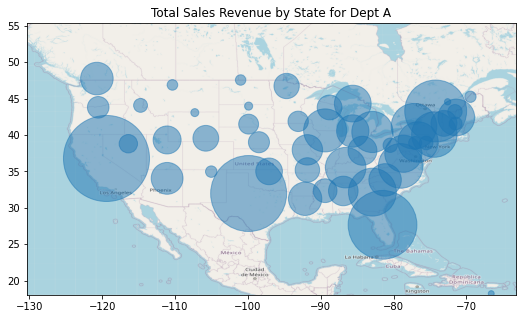

In [22]:
# Latitude and Longitude boundaries for the us_map image
BBox = (-130.34, -63.19,      
         18.06, 55.38)

# import us_map image
us_m = plt.imread('C:\\Users\\Shalie\\Documents\\Springboard\\CapstoneTwo\\us_map.png')

# plot scatter plot of revenue for each state for Dept A on the image
fig, ax = plt.subplots()
_ = ax.scatter(State_Sales_A.longitude, State_Sales_A.latitude, s=0.15*(State_Sales_A['product sales']), zorder=1, alpha=0.5)

_ = ax.set_title('Total Sales Revenue by State for Dept A')
_ = ax.set_xlim(BBox[0],BBox[1])
_ = ax.set_ylim(BBox[2],BBox[3])

_ = ax.imshow(us_m, zorder=0, extent=BBox, aspect='equal')

print('Not pictured: AK and HI')

Not pictured: AK and HI


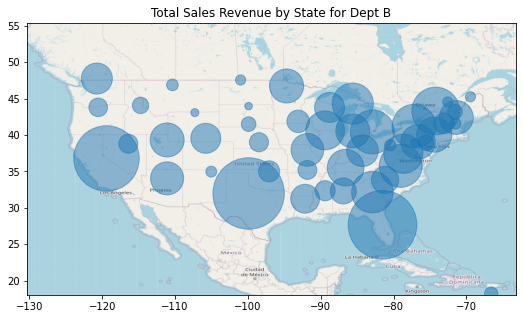

In [23]:
# plot scatter plot of revenue for each state for Dept B on the image
fig, ax = plt.subplots()
_ = ax.scatter(State_Sales_B.longitude, State_Sales_B.latitude, s=0.15*(State_Sales_B['product sales']), zorder=1, alpha=0.5)

_ = ax.set_title('Total Sales Revenue by State for Dept B')
_ = ax.set_xlim(BBox[0],BBox[1])
_ = ax.set_ylim(BBox[2],BBox[3])

_ = ax.imshow(us_m, zorder=0, extent=BBox, aspect='equal')

print('Not pictured: AK and HI')

In [ ]:
# It would appear that the revenue for each department for each state is distributed according to respective population.

## Insights:

Since its inception in 2018, “Amazon Startup” has grown to offer 12 different products taking a small, but reliable, portion of the Amazon market share in two different product categories. Recently, the Covid-19 pandemic has disrupted production and shipping channels, and caused the sustained loss of sales opportunities at various times in the 2020 year. 

With the Covid-19 vaccine being distributed, there are hopes for a return to a new normal and to reliable sales and shipping. Management has concluded that a new strategy in marketing and new criteria for success in product performance is needed for 2021.

The goals of this analysis were to:
* **Define Goal for FY2021:** Find the average growth rate prior to the onset of the pandemic.
* **Product Performance:** Focus resources towards well performing products and away from poorly performing products.
* **Marketing Strategy:** Optimize marketing according to seasonality and geographical regions.

### <span style="color:green">Sales Growth Goal for FY2021</span> 

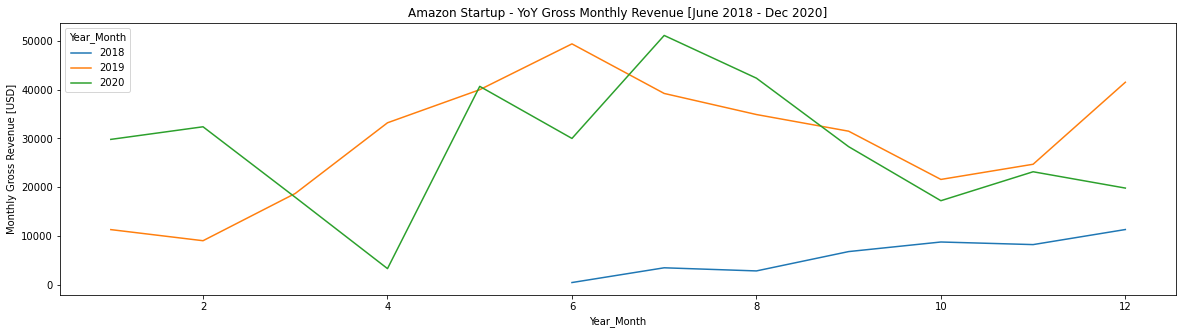

In [24]:
_ = total_sales_yearly.plot(kind='line')
_ = plt.title('Amazon Startup - YoY Gross Monthly Revenue [June 2018 - Dec 2020]')
_ = plt.ylabel('Monthly Gross Revenue [USD]')

            quantity  product sales     zip_5  cum_sales  Last_Year cum_sales  \
Year_Month                                                                      
2019-06-01    1596.0       49366.21  67867766  203740.62               486.83   
2019-07-01    1528.0       39212.41  62592121  242953.03              3993.80   
2019-08-01    1365.0       34895.15  59094942  277848.18              6860.00   
2019-09-01    1388.0       31481.46  61675719  309329.64             13687.73   
2019-10-01     991.0       21604.38  43438865  330934.02             22477.00   
2019-11-01    1125.0       24712.82  52331691  355646.84             30734.61   
2019-12-01    1998.0       41508.09  91269255  397154.93             42077.58   
2020-01-01    1581.0       29804.33  75398252  426959.26             53404.76   
2020-02-01    1623.0       32386.49  76233962  459345.75             62457.17   
2020-03-01     925.0       17944.19  44281991  477289.94             81188.15   
2020-04-01     155.0        

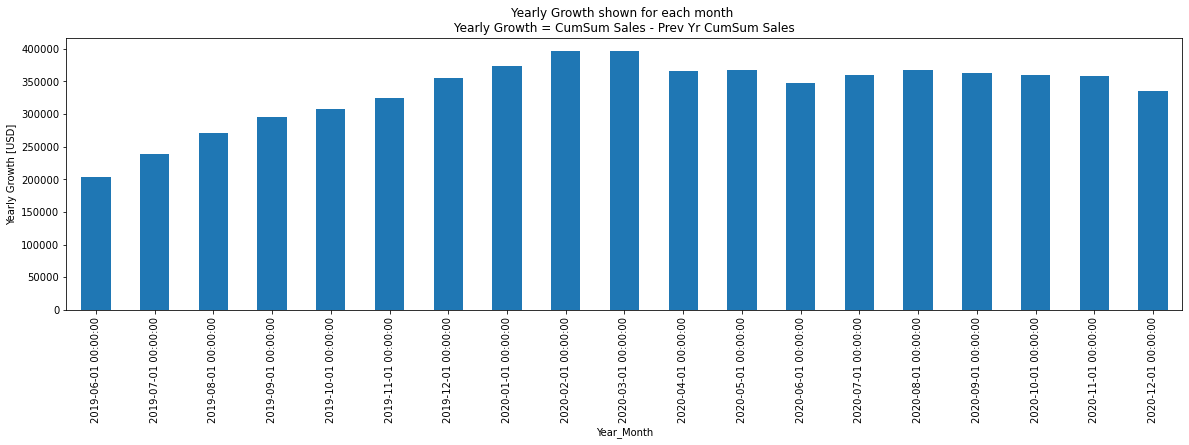

In [25]:
Total_Rev_Monthly['cum_sales'] = Total_Rev_Monthly['product sales'].cumsum()
Total_Rev_Monthly['Last_Year cum_sales'] = np.roll(Total_Rev_Monthly['cum_sales'],12)
Total_Rev_Monthly = Total_Rev_Monthly.drop(Total_Rev_Monthly.index[0:12])
Total_Rev_Monthly['Yearly Growth'] = Total_Rev_Monthly['cum_sales'] - Total_Rev_Monthly['Last_Year cum_sales']

_=Total_Rev_Monthly['Yearly Growth'].plot(kind='bar')
_=plt.title('Yearly Growth shown for each month \n Yearly Growth = CumSum Sales - Prev Yr CumSum Sales ')
_=plt.ylabel('Yearly Growth [USD]')

YearlyGrowthGoal = round(Total_Rev_Monthly['2019-09':'2020-02']['Yearly Growth'].mean(),2)
FY2020Sales = round(Total_Rev_Monthly['2020']['product sales'].sum(),2)

print(Total_Rev_Monthly)
print('\n')

print('Average yearly growth rate [2019-09 to 2020-02]:', \
      YearlyGrowthGoal, '[USD] per year more than the year before')
print('\n')
print('Given the FY2020 total sales of', FY2020Sales, ', the gross sales goal for FY2021 should be', \
      (YearlyGrowthGoal + FY2020Sales), '[USD]')

In [27]:
# Summing quantity sold by Department and Year_Month
QtySales_per_Dept_20 = pd.DataFrame(df_sales[df_sales.index.year == 2020].groupby(['Year_Month', 'Department']).sum()['quantity'])
QtySales_per_Dept_20.reset_index(level=1, inplace=True)
QtySales_20 = pd.DataFrame(QtySales_per_Dept_20.groupby(['Department']).mean())

print('Average Quantity Sold per month in FY2020 for both departments: \n')
print(QtySales_20)

Average Quantity Sold per month in FY2020 for both departments: 

            quantity
Department          
A              947.0
B              344.0


#### Key Insights:

1. The first plot shows that gross revenue consistently exceeded the previous year's respective value for every month until February 2020. From that point onward, gross sales for each month bounced around the previous year's numbers.
2. The second plot supports this by showing the yearly sales growth rate as it shifted over time. Cumulative sales was consistently increasing at an average rate of approx. 340,000 USD/year until the supply chain became inconsistent.
3. Management's goal of regaining the pre-pandemic growth rate equates to a gross sales goal of approx. **680,000 USD for FY2021.**

**This sales goal is highly achievable for these reasons:**
* Using JungleScout software to estimate market size for both departments, it was determined: 

i. the top 200 sellers in department A make approx. 600 sales per month each. Given that the top 200 sellers together are selling around 120,000 products per month, there is plenty of room for expansion in department A. 

ii. the top 200 sellers in department B make approx. 450 sales per month each. Given that the top 200 sellers together are selling around 90,000 products per month, there is plenty of room for expansion in department B.
* A lot of potential sales were missed at the peak of the summer season in 2019 and 2020 due to unrelated inventory issues. With great intentionality, this can be avoided in 2021.

To meet this goal, two areas of strategy need to be re-evaluated to optimize the chance for success:
* **Product Performance**
* **Marketing**

### <span style="color:green">Product Performance</span> 

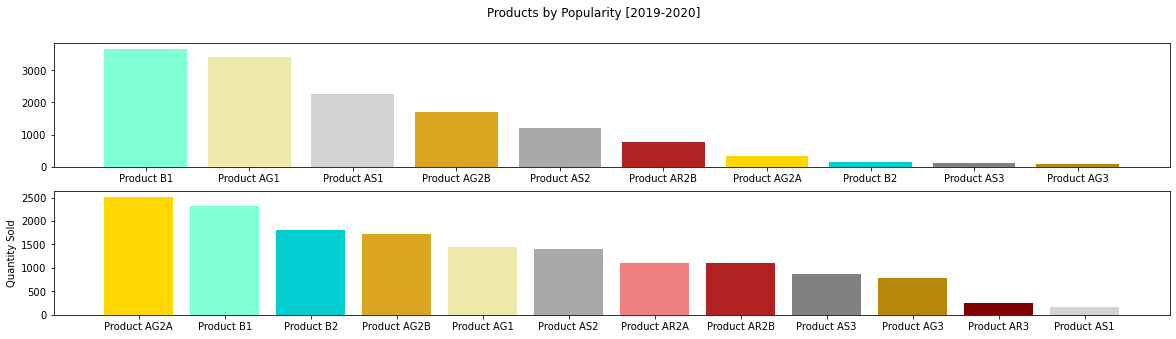

In [28]:
Product_Pop_2019 = pd.DataFrame(df_sales[df_sales.index.year == 2019].groupby('sku').sum()['quantity'])
Product_Pop_2020 = pd.DataFrame(df_sales[df_sales.index.year == 2020].groupby('sku').sum()['quantity'])

Product_Pop_2019.sort_values(by=['quantity'], inplace=True, ascending=False)
Product_Pop_2020.sort_values(by=['quantity'], inplace=True, ascending=False)

Product_Pop_2019.reset_index(level=0, inplace=True)
Product_Pop_2020.reset_index(level=0, inplace=True)

fig, axs = plt.subplots(2)
_=axs[0].bar(Product_Pop_2019['sku'], Product_Pop_2019['quantity'], \
       color=Product_Pop_2019['sku'].apply(lambda c: prod_colors[c]))
_=axs[1].bar(Product_Pop_2020['sku'], Product_Pop_2020['quantity'], \
       color=Product_Pop_2020['sku'].apply(lambda c: prod_colors[c]))
_=fig.suptitle('Products by Popularity [2019-2020]')
_=plt.ylabel('Quantity Sold')

             sku  mean quantity  mean price  mean revenue
10    Product B1     193.583333   37.640434   7658.400833
11    Product B2     150.416667   46.850002   7141.747500
0    Product AG1     119.833333   24.553571   2897.220000
2   Product AG2B     143.166667   16.736809   2418.081667
1   Product AG2A     209.000000   11.373321   2374.328333
4   Product AR2A     159.142857   11.566836   1829.268571
5   Product AR2B      92.583333   16.930619   1580.322500
8    Product AS2     117.333333    8.848635   1026.076667
7    Product AS1      32.400000   22.868460    738.694000
3    Product AG3      64.666667   10.915708    704.353333
9    Product AS3      72.583333    8.268397    596.774167
6    Product AR3      36.857143   11.030140    410.345714


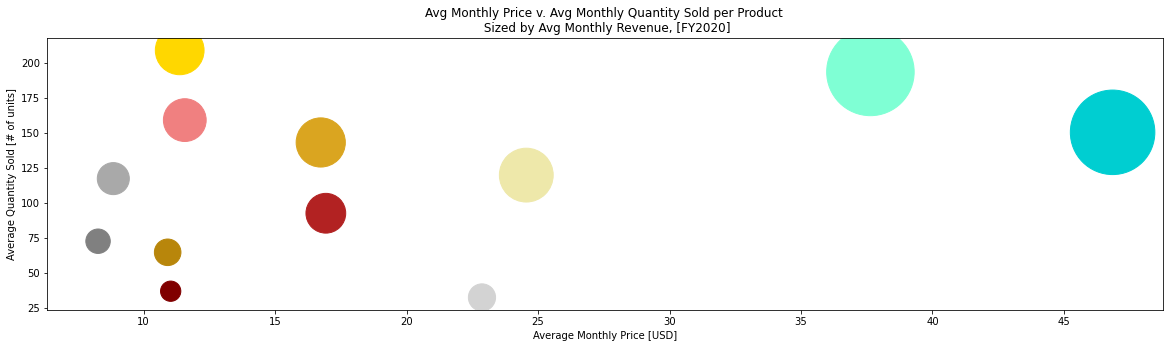

In [29]:
Product_Avgs_20.sort_values(by=['mean revenue'], inplace=True, ascending=False)
print(Product_Avgs_20)

fig, ax = plt.subplots()
_=ax.scatter(Product_Avgs_20['mean price'], Product_Avgs_20['mean quantity'], \
           s=Product_Avgs_20['mean revenue'], c=Product_Avgs_20['sku'].apply(lambda c: prod_colors[c]), alpha=1)

_=plt.title('Avg Monthly Price v. Avg Monthly Quantity Sold per Product \n Sized by Avg Monthly Revenue, [FY2020]')
_=plt.xlabel('Average Monthly Price [USD]')
_=plt.ylabel('Average Quantity Sold [# of units]')

#### Key Insights:

1. The bar plots show how product popularity has developed over time. Of the original three products (B1, AG1, and AS1), B1 and AG1 have continued to be competitive while AS1 has not.
2. The new products introduced in 2019 have all grown in popularity with product AG2A becoming the most popular product overall with the highest quantity sold.
3. The scatter plot shows the relationship between quantity sold and gross revenue. Though the products in department A and B have comparable average monthly quantities sold, the products in department B have a higher selling price and generate far more gross revenue.
4. In department A, the subset of AG products are most popular and generate the most revenue.

**Recommendations:**
With limited capital from pandemic-affected sales in 2020, resources should be allocated away from poorly performing products and invested in well performing products.
* Consider divesting the AS1 product. It has dropped in popularity and generates relatively little revenue for a well established product.
* As the AG set of products are the most popular in department A, marketing resources should be focused to promoting these products.
* Department B's products have similar popularity to those in department A, but also have a higher selling price. This could be a good opportunity to introduce a new product in department B which is likely to perform well in the market at a similar price. This is likely to be the best way to meet the sales goal for FY2021.

### <span style="color:green">Marketing Strategy</span> 

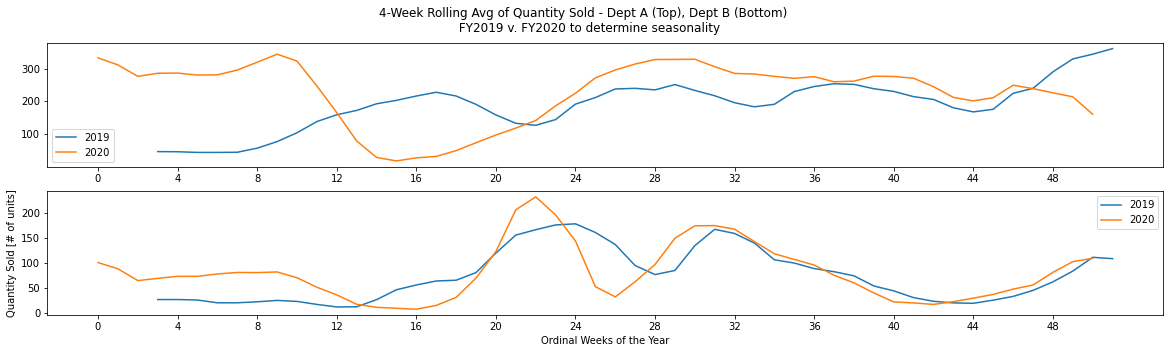

In [30]:
fig, axs = plt.subplots(2)
_=WeeklyQuantity_A_Yr.plot(kind='line', ax=axs[0])
_=WeeklyQuantity_B_Yr.plot(kind='line', ax=axs[1])
_=fig.suptitle('4-Week Rolling Avg of Quantity Sold - Dept A (Top), Dept B (Bottom)  \n FY2019 v. FY2020 to determine seasonality')
_=plt.ylabel('Quantity Sold [# of units]')
_=plt.xlabel('Ordinal Weeks of the Year')
_=axs[0].set_xticks(np.arange(min(WeeklyQuantity_A_Yr.index), max(WeeklyQuantity_A_Yr.index)+1, 4.0))
_=axs[1].set_xticks(np.arange(min(WeeklyQuantity_B_Yr.index), max(WeeklyQuantity_B_Yr.index)+1, 4.0))
plt.show()

Not pictured: AK and HI


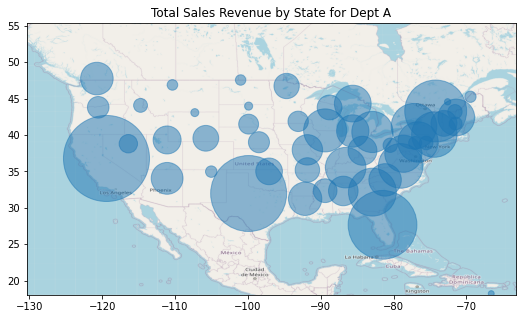

In [31]:
fig, ax = plt.subplots()
_ = ax.scatter(State_Sales_A.longitude, State_Sales_A.latitude, s=0.15*(State_Sales_A['product sales']), zorder=1, alpha=0.5)
_ = ax.set_title('Total Sales Revenue by State for Dept A')
_ = ax.set_xlim(BBox[0],BBox[1])
_ = ax.set_ylim(BBox[2],BBox[3])
_ = ax.imshow(us_m, zorder=0, extent=BBox, aspect='equal')
print('Not pictured: AK and HI')

Not pictured: AK and HI


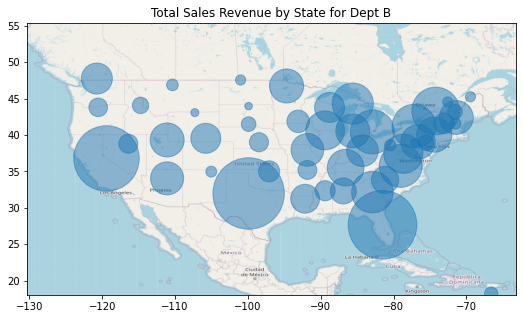

In [32]:
fig, ax = plt.subplots()
_ = ax.scatter(State_Sales_B.longitude, State_Sales_B.latitude, s=0.15*(State_Sales_B['product sales']), zorder=1, alpha=0.5)
_ = ax.set_title('Total Sales Revenue by State for Dept B')
_ = ax.set_xlim(BBox[0],BBox[1])
_ = ax.set_ylim(BBox[2],BBox[3])
_ = ax.imshow(us_m, zorder=0, extent=BBox, aspect='equal')
print('Not pictured: AK and HI')

#### Key Insights:

1. The rolling average of sales shown in the line plots above show the seasonality for the two departments. Department A appears to have little seasonality with more of a steady increase in sales over time. Department B has a pronounced summer season with an uptick in sales during the holiday season. The midsummer dip in sales for Department B are due to stocking issues which are potentially avoidable in coming years.
2. The regional distribution of sales shown in the two maps for the two departments appear to be primarily distributed according to population density.

**Recommendations:**

* Marketing resources for department A can be equally useful distributed evely across the seasons. 
* Marketing resources for department B should be increased during the summer and holiday seasons to maximize the upswing in sales.
* Since regional distribution appears most associated with population density, focusing marketing resources to highly populated areas is only useful if breaking it up regionally is cheaper than marketing to all areas equally.